## Evaluation of Experiments

In this notebook the experiments are evaluated for the RS paper 

Set up envornmental variables:

In [2]:
import tensorflow as tf
import os
import re
import glob

In [3]:
savedir = r"E:\acocac\research\paper\models\compare\ep20"

e = ['all','bandsaux','bands','indices']

dataset = "test"
rolling_mean_window = 2

def params2name(e):
    return "convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_{}".format(e)

runs = [] # expected runs
for e_ in e:
    runs.append(params2name(e_))

extract data from Tensorflow event files:

walk through all event files and extract cross entropy:

In [4]:
def extract_from_eventfile(eventfile_path, tag):
    steps = []
    values = []

    for e in tf.train.summary_iterator(eventfile_path):
        for v in e.summary.value:
            if v.tag == tag:
                steps.append(e.step)
                values.append(v.simple_value)

    return steps, values

def extract_from_all_eventfiles(path, target, tag):
    """ 
    appends values from all event files in one folder
    if path does not exist: returns empty list
    """
    steps = []
    values = []
    
    if os.path.exists(path):
        eventfiles = glob.glob(os.path.join(path,target,'*.ATLANTIC'))
    else:
        return steps, values # empty
    
    for eventfile in eventfiles:
        steps_,values_ = extract_from_eventfile(os.path.join(path,eventfile), tag=tag)
        steps.extend(steps_)
        values.extend(values_)
        
    return steps, values

def gather_data_from_multiple_runs(folder_path, runs, dataset="test2009", tag='xe'):
    """
    look through all save folders defined by runs, extract eventfiles from runs
    and append everything to pandas dataframe
    """

    series = []
    for run in runs:
        path = os.path.join(folder_path,run)
        steps,values = extract_from_all_eventfiles(path, dataset, tag)
        print("run: {} extracted {} values".format(run,len(values)))   

        if len(values) > 0:

            s = pd.Series(data=values, index=steps,name=run).sort_index()
            # drop duplicates
            s = s[~s.index.duplicated(keep='last')]

            #.drop_duplicates(keep='last')
            series.append(s)
            
    return pd.concat(series,axis=1,join="outer")

In [6]:
import pandas as pd
import numpy as np

def smooth_and_interpolate(data, rolling_mean_window = 10):
    data.interpolate(axis=1,inplace=True)
    return data.rolling(window=rolling_mean_window,axis=0).mean()

def get_best_run(data,max_is_better=False):
    scores = []
    for col in data.columns: 
        s = data[col]
        scores.append(s.loc[s.last_valid_index()])
    
    if max_is_better:
        return data.columns[np.array(scores).argmax()]
    else:
        return data.columns[np.array(scores).argmin()]

dataset = 'test2009'

# cross entropy
tag='xe'
data = gather_data_from_multiple_runs(savedir,runs,'test2009',tag)
data_smooth = smooth_and_interpolate(data,rolling_mean_window)

run: convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_all extracted 1040 values
run: convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_bandsaux extracted 1039 values
run: convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_bands extracted 1040 values
run: convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_indices extracted 1040 values


### Plot cross entropy over time for all networks

In [7]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import rgb2hex
%matplotlib inline
import seaborn as sns
import numpy as np

### Check completeness of training

Extract indeces of first event and last event for all networks to test if the networks have all trained completely

In [6]:
out = []
for run in runs:
    if run in data.columns:
        col = data[run]
        first_valid = col.first_valid_index()
        last_valid = col.last_valid_index()
    else:
        first_valid = None
        last_valid = None

    out.append({"run":run, "first_valid":first_valid, "last_valid":last_valid})

check_df = pd.DataFrame(out).set_index("run")
# first_valid_by_network = d.pivot(columns='network', values='first_valid')
# last_valid_by_network = d.pivot(columns='network', values='last_valid')

In [8]:
check_df

,first_valid,last_valid
run,,
convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_all,32.0,1058848.0
convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_bandsaux,32.0,1058848.0
convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_bands,NaN,NaN
convgru64_p24pxk0px_batch32_09_MCD12Q1v6_cleaned_8d_l1_bidir_indices,32.0,1058848.0


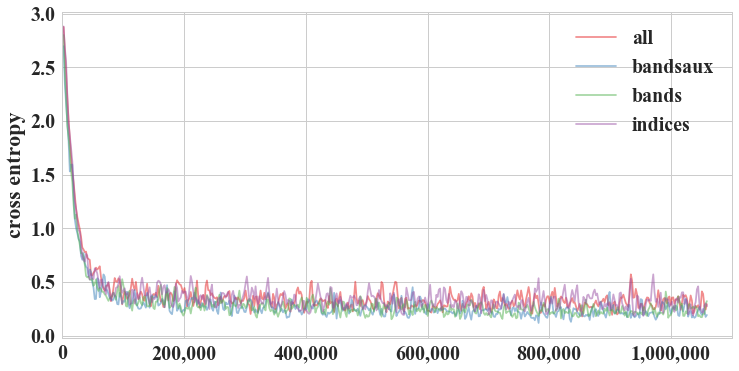

In [7]:
cols = sns.color_palette("Set1", n_colors=len(e))

colormapping = dict(zip(e,cols))

def plot_by_l(data, colormapping, ax=None, cols=["blue","green","red"]):
    if ax is None:
        f, ax = plt.subplots()
    
    runs = data.columns
    for run in runs:
        p = run.split('_')[-1]
        col = colormapping[p]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, alpha=0.5)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
#     ax.set_xlim(0,1e6)
    ax.set_xlim(0,1.1e6)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_l(data_smooth, colormapping,ax=ax)
#     ax.legend(["All","Bands","Bandsaux","Indices"])
    ax.legend(list(colormapping.keys()))

In [9]:
list(colormapping.keys())

['all', 'bandsaux', 'bands', 'indices']